In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [23]:
# y -> outlet liquid temperature
# q(t) -> liquid flow rate
# Narx -> yhat(t+1|t) = f(y(t) ... y(t-3) u(t) ... u(t-9))

#read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]
u = [float(x[1]) for x in lst]
y = [float(x[2]) for x in lst]

In [26]:
#divide identification set and validation set
ID_LENGHT = 3000
VAL_LENGHT = 1000
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]
avg_y_id = np.mean(y_id)
avg_u_id = np.mean(u_id)

time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]
avg_y_val = np.mean(y_val)
avg_u_val = np.mean(u_val)


AR_deg = 4
X_deg = 10
n_hidden = 2
unit_per_hidden = tuple([14,7])

In [46]:
Y = np.array(y_id)
for k in range(100):
    mlp = MLPRegressor(hidden_layer_sizes=unit_per_hidden,activation="logistic", solver="lbfgs",\
                       verbose=True, random_state=k)
    reg_u = np.full(X_deg,avg_u_id)
    reg_y = np.full(AR_deg,avg_y_id)
    PHI = []
    for i in range(ID_LENGHT):
        if i!=0:
            reg_y = np.append(reg_y, Y[i])[1:]
            reg_u = np.append(reg_u, u_id[i])[1:]
        regressors = np.append(reg_u, reg_y)
        PHI.append(regressors)
    PHI = np.array(PHI)
    model = mlp.fit(PHI,Y)
    print(k, model.loss_)

0 0.0434409108778
1 1.54485914621
2 1.54485096669
3 1.54485439193
4 1.54486018297
5 1.54486451575
6 1.54484569814
7 1.54485821319
8 1.54484936243
9 1.5448422445
10 0.0596006681199
11 1.54484574842
12 1.5448492715
13 0.0505821633034
14 0.0468155292953
15 0.0441906226017
16 1.54485157919
17 0.0477501012417
18 1.54485002326
19 1.54485273764
20 1.5448520707
21 1.54484788433
22 1.54485556335
23 1.54486720793
24 0.0504461004517
25 0.0430810033505
26 1.54485474388
27 1.54484888706
28 1.54487349732
29 0.0466443662573
30 1.54487708389
31 1.54484313908
32 0.0480566900181
33 1.544845709
34 1.54486594642
35 1.54485541461
36 1.54485657155
37 1.54485347369
38 1.54484819199
39 1.54485491344
40 1.5448772812
41 1.54485394656
42 1.54484932182
43 1.54485433956
44 0.0469046766333
45 1.54485155822
46 0.0460793901325
47 1.54485086947


KeyboardInterrupt: 

In [124]:
mlp = MLPRegressor(hidden_layer_sizes=(14,7),activation="logistic", solver="lbfgs", verbose=True, random_state=13)

In [125]:
Y = np.array(y_id)
reg_u = np.full(X_deg,avg_u_id)
reg_y = np.full(AR_deg,avg_y_id)
PHI = []
for i in range(ID_LENGHT):
    if i!=0:
        reg_y = np.append(reg_y, Y[i])[1:]
        reg_u = np.append(reg_u, u_id[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI.append(regressors)
PHI = np.array(PHI)

In [126]:
model = mlp.fit(PHI,Y)

In [127]:
y_hat = model.predict(PHI)

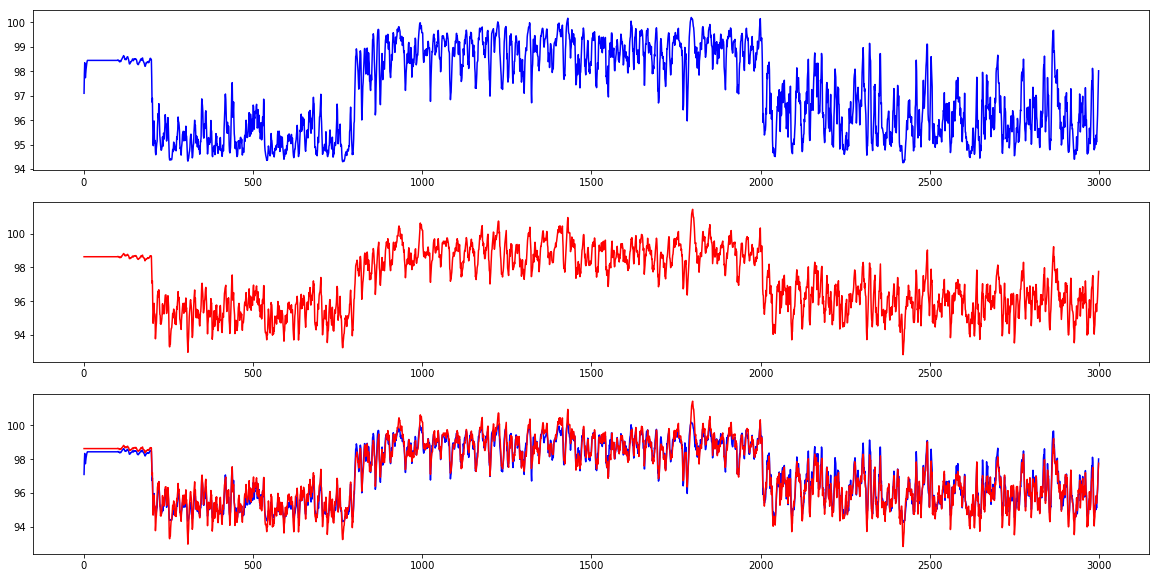

MSE on identification:  0.101106830625


In [128]:
plt.subplot(311)
plt.plot(y_hat, color='blue')
plt.subplot(312)
plt.plot(y_id, color='red')
plt.subplot(313)
plt.plot(y_hat, color='blue')
plt.plot(y_id, color='red')
plt.show()

MSE_id = mean_squared_error(y_id,y_hat)
print("MSE on identification: ", MSE_id)

In [129]:
Y_val = np.array(y_val)
reg_u = np.full(X_deg,avg_u_val)
reg_y = np.full(AR_deg,avg_y_val)
PHI_val = []
for i in tqdm(range(VAL_LENGHT)):  
    if i!=0:
        reg_y = np.append(reg_y, Y_val[i])[1:]
        reg_u = np.append(reg_u, u_val[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI_val.append(regressors)
PHI_val = np.array(PHI_val)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 37038.41it/s]


In [130]:
y_hat_val = model.predict(PHI_val)

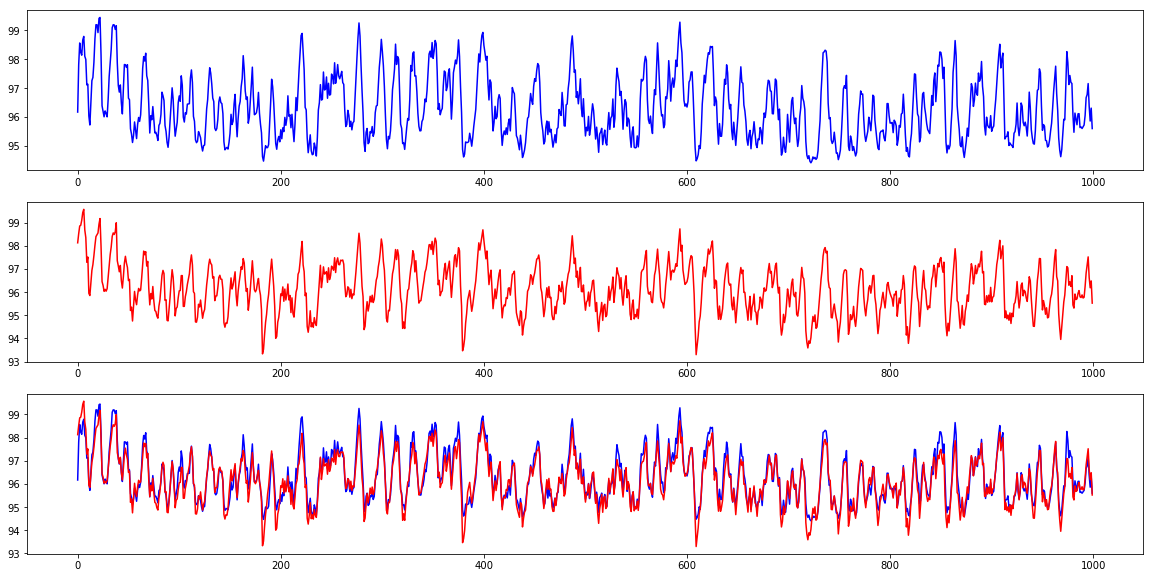

MSE on validation:  0.129353787586


In [131]:
plt.subplot(311)
plt.plot(y_hat_val, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_val, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_val = mean_squared_error(y_val,y_hat_val)
print("MSE on validation: ", MSE_val)

(-1, 1)

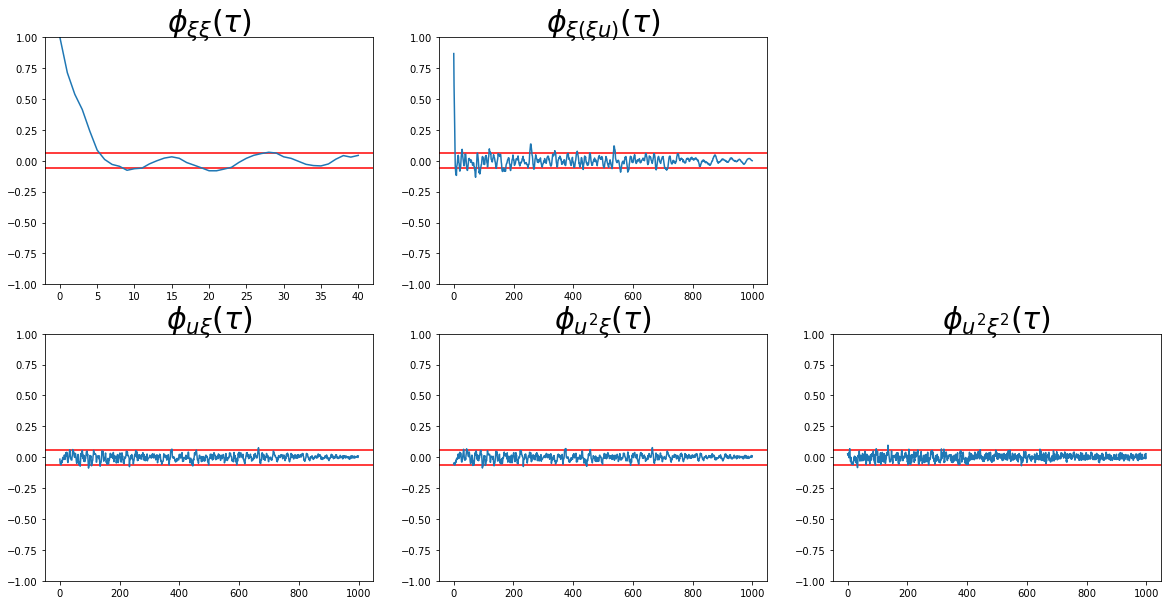

In [132]:
#MODEL VALIDATION - CORRELATION FUNCTIONS
from statsmodels.tsa.stattools import acf , ccf
epsilon = np.array(y_val - y_hat_val)
u_val = np.array(u_val)

#Autocorrelation epsilon
corr_ee = acf(epsilon)

#Cross-correlation u-epsilon
corr_ue = ccf(u_val, epsilon,unbiased=False)

#Cross-correlation epsilon ( epsilon*u)
corr_e_eu = ccf(epsilon,np.multiply(epsilon[1:],u_val[1:]),unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),epsilon, unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e2 = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),np.power(epsilon,2), unbiased=False)

#confidence interval   -95%
conf_interval_sup = 1.96 / np.sqrt(VAL_LENGHT)
conf_interval_inf = -1.96 / np.sqrt(VAL_LENGHT)
plt.subplot(231)
plt.title(r'$\phi_{\xi\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ee)
plt.ylim((-1,1))
plt.subplot(232)
plt.title(r'$\phi_{\xi(\xi u)}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_e_eu)
plt.ylim((-1,1))
plt.subplot(234)
plt.title(r'$\phi_{u \xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ue)
plt.ylim((-1,1))
plt.subplot(235)
plt.title(r'$\phi_{u^2\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e)
plt.ylim((-1,1))
plt.subplot(236)
plt.title(r'$\phi_{u^2\xi^2}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e2)
plt.ylim((-1,1))


In [133]:
## Simulation ON VALIDATION 
# start from initial phi, then build step by step each ne element
reg_y = np.full(AR_deg,avg_y_val)
reg_u = np.full(X_deg,avg_u_val)
reg = np.append(reg_u,reg_y)

In [134]:
#simulate the process
y_hat_sim  = []
for i in range(VAL_LENGHT):
    y_i = model.predict([reg]) #simulated
    y_hat_sim.append(y_i)
    reg_y = np.append(reg_y, y_hat_sim[i])[1:]
    reg_u = np.append(reg_u, u_val[i])[1:]  #append at beggining, then remove last one( [:-1])
    reg = np.append(reg_u,reg_y)

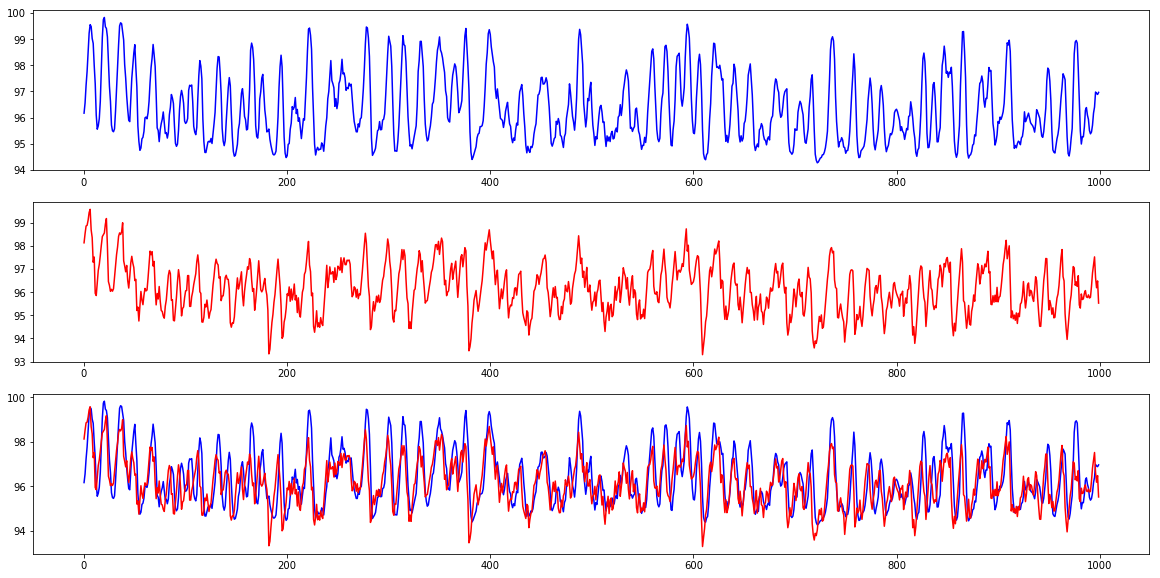

MSE on simulation:  1.03072765246


In [135]:
plt.subplot(311)
plt.plot(y_hat_sim, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_sim, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_sim = mean_squared_error(y_val,y_hat_sim)
print("MSE on simulation: ", MSE_sim)

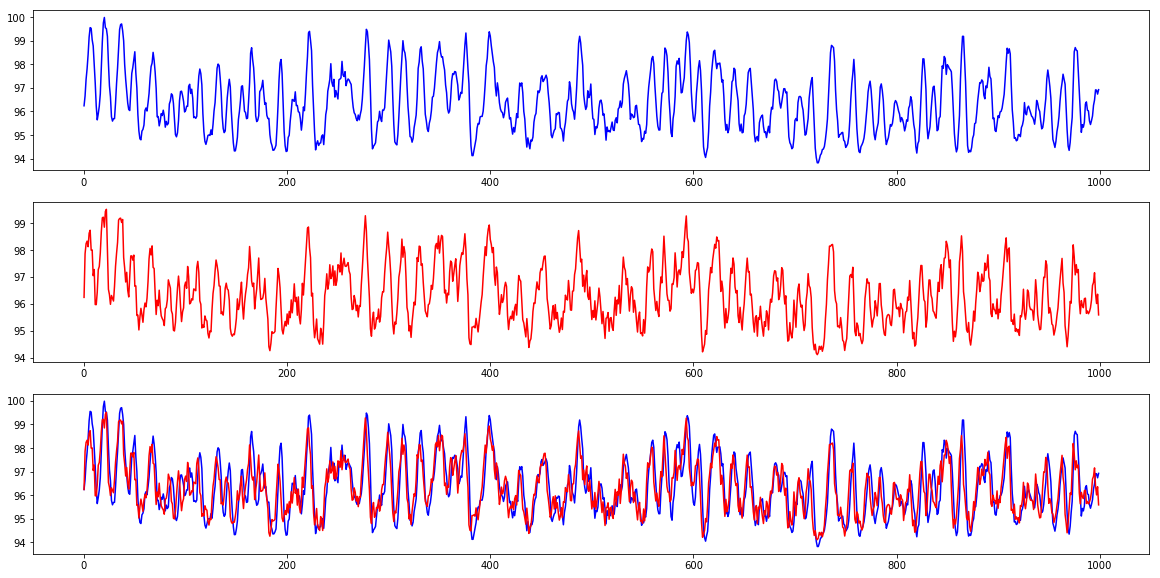

MSE on simulation:  0.6532436024


In [59]:
plt.subplot(311)
plt.plot(y_hat_sim, color='blue')
plt.subplot(312)
plt.plot(y_hat_val, color='red')
plt.subplot(313)
plt.plot(y_hat_sim, color='blue')
plt.plot(y_hat_val, color='red')
plt.show()
MSE_sim_pred = mean_squared_error(y_hat_val,y_hat_sim)
print("MSE on simulation: ", MSE_sim_pred)

In [60]:
## Simulation ON IDENTIFICATION 
# start from initial phi, then build step by step each ne element
reg_y = np.full(AR_deg,avg_y_id)
reg_u = np.full(X_deg,avg_u_id)
reg = np.append(reg_u,reg_y)

In [61]:
#simulate the process
y_hat_sim_id  = []
for i in range(ID_LENGHT):
    y_i = model.predict([reg]) #simulated
    y_hat_sim_id.append(y_i)
    reg_y = np.append(reg_y, y_hat_sim_id[i])[1:]
    reg_u = np.append(reg_u, u_id[i])[1:]  #append at beggining, then remove last one( [:-1])
    reg = np.append(reg_u,reg_y)

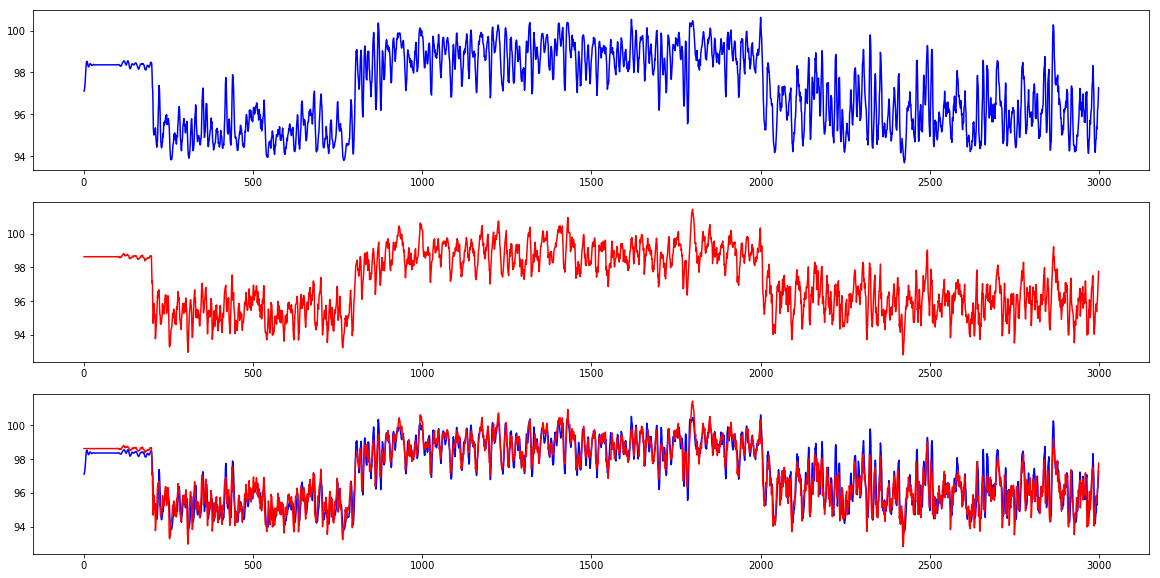

MSE on simulation:  0.436881950769


In [62]:
plt.subplot(311)
plt.plot(y_hat_sim_id, color='blue')
plt.subplot(312)
plt.plot(y_id, color='red')
plt.subplot(313)
plt.plot(y_hat_sim_id, color='blue')
plt.plot(y_id, color='red')
plt.show()

MSE_sim_id = mean_squared_error(y_id,y_hat_sim_id)
print("MSE on simulation: ", MSE_sim_id)

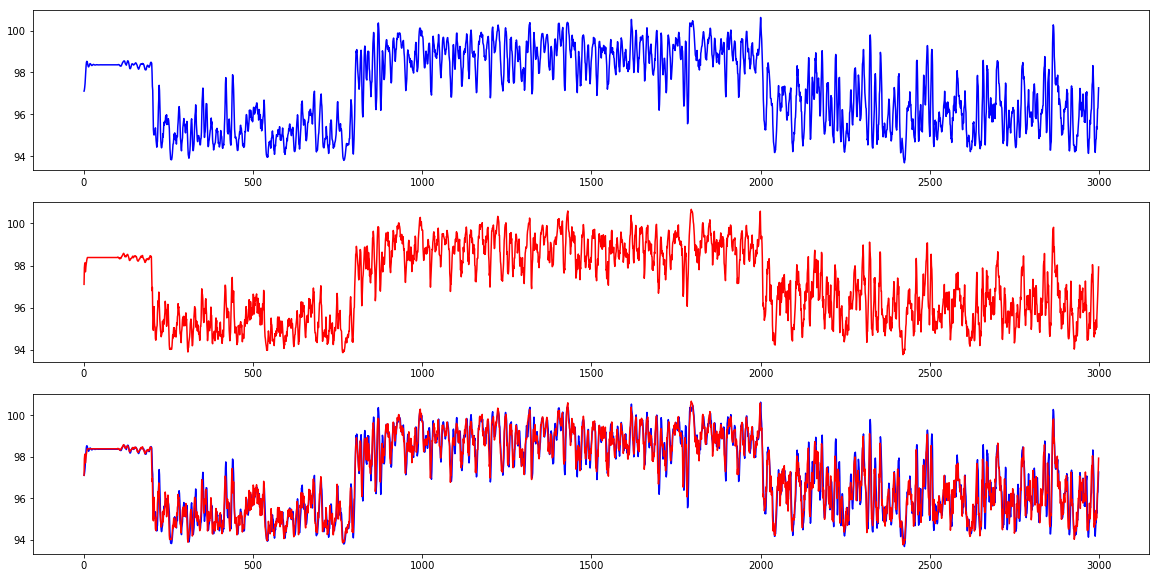

MSE on simulation:  0.317163580989


In [63]:
plt.subplot(311)
plt.plot(y_hat_sim_id, color='blue')
plt.subplot(312)
plt.plot(y_hat, color='red')
plt.subplot(313)
plt.plot(y_hat_sim_id, color='blue')
plt.plot(y_hat, color='red')
plt.show()
MSE_sim_id_pred = mean_squared_error(y_hat,y_hat_sim_id)
print("MSE on simulation: ", MSE_sim_id_pred)